In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.random import randint
from scipy.cluster.hierarchy import ward, fcluster

## MetroMap Implementation

### 1. Read computed SOM

In [2]:
from SOMToolBoxParser import SOMToolBoxParser

input_vectors = SOMToolBoxParser("datasets/chainlink/chainlink.vec").read_weight_file()
weight_vectors = SOMToolBoxParser("datasets/chainlink/chainlink_small.wgt.gz").read_weight_file()

### 2.a Component Planes

For each unit, take the weight vector of the corresponding attribute

In [3]:
## TODO: figure out shape of the input weight matrix: attr,x,y or attr,y,x
## TODO: last argument of .reshape

component_planes = np.array([weight_vectors['arr'][:, i] for i in range(weight_vectors['vec_dim'])]).reshape(
    weight_vectors['vec_dim'], weight_vectors['xdim'], weight_vectors['ydim'])
component_planes

array([[[-9.88067744e-01, -9.06554274e-01, -9.48086143e-01, ...,
         -6.60731600e-01, -5.13187663e-01, -4.49753301e-01],
        [-4.19260764e-01, -3.24941405e-01, -2.37149372e-01, ...,
          9.44323514e-02,  6.72223703e-02,  4.56587289e-02],
        [-9.40169540e-01, -9.29182666e-01, -9.63767380e-01, ...,
         -6.13400118e-01, -4.98529682e-01, -4.40056021e-01],
        ...,
        [ 1.78840761e-04, -3.55183452e-03, -2.56285017e-02, ...,
          2.48889138e-02,  5.34319834e-02,  6.16743961e-02],
        [ 2.49022345e-01,  3.16478029e-01,  4.42975512e-01, ...,
         -7.15477430e-02, -6.10488531e-02, -4.44377143e-02],
        [-4.12160088e-02,  2.80587481e-02, -4.32241645e-02, ...,
          7.29521912e-02,  5.93679447e-02,  6.17028558e-02]],

       [[ 1.44292870e+00,  1.37250339e+00,  1.32271505e+00, ...,
          1.60897800e-01,  9.76336657e-02,  1.01358791e-01],
        [ 4.75229704e-02, -9.02778024e-03,  8.20536158e-02, ...,
         -1.02322376e+00, -1.01394619e

### 2.b Discretization

Input parameter `n`: number of bins

<AxesSubplot:>

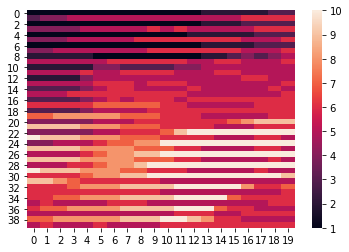

In [4]:
n = 10
discretized_planes = []

for component_plane in component_planes:
    bins = np.linspace(component_plane.min(), component_plane.max(), n, False)
    discretized_plane = np.digitize(component_plane, bins)
    discretized_planes.append(discretized_plane)

sns.heatmap(discretized_planes[0])

### 3. Component Lines (Fi)

Based on the algorith of NEU07_ijcnn, the following steps need to be performed:
For each component, take a region (bins) and check which points fall within the interval of the region. Sum the values up, and divide the sum by the number of points in the region. The result is the gravity center of a component's region. Repeat these steps for all regions.

In [5]:
def calculate_region_center(points):
    return sum(points) / len(points)


def get_points_inside_region(region, component):
    return np.argwhere(component == region)


def get_region_centers(component):
    region_centers = []
    for region_index in range(n):
        region = region_index + 1
        included_points = get_points_inside_region(region, component)
        region_center = calculate_region_center(included_points)
        region_centers.append(region_center)
    return region_centers


def get_component_lines(binned_planes):
    """ returns e.g., [[[1,2], [3,4], [3,5]], [...], [...]] -> component plane 0 has line with points: (1,2), (3,4) (3,5)"""
    lines = []
    for component in binned_planes:
        region_centers = get_region_centers(component)
        lines.append(region_centers)
    return lines


def get_high_low_lines(lines):
    """ returns e.g., [[[3, 8], [4,8]], [...]] -> component plane 0 (line 0) has min at (3,8), max at (4,8) """
    lines_min_max = []
    for line in lines:
        start = line[0]
        end = line[-1]
        lines_min_max.append([start, end])
    return lines_min_max


lines = np.array(get_component_lines(discretized_planes))
lines_min_max = np.array(get_high_low_lines(lines))

lines

array([[[ 3.66101695,  6.23728814],
        [ 6.18181818,  9.03030303],
        [ 9.25806452,  9.64516129],
        [12.63636364,  3.57575758],
        [19.09623431, 10.56903766],
        [21.19211823, 11.09852217],
        [25.73809524,  6.95238095],
        [28.3877551 ,  5.67346939],
        [28.73913043,  6.36956522],
        [27.93846154, 13.46153846]],

       [[11.16216216, 16.47297297],
        [16.85454545, 13.27272727],
        [20.17857143, 10.89285714],
        [17.75630252,  7.97478992],
        [19.83783784,  8.36936937],
        [19.34042553, 11.55319149],
        [20.70175439, 10.56140351],
        [20.08510638,  8.14893617],
        [22.48      ,  5.7       ],
        [26.95      ,  2.5625    ]],

       [[34.97014925, 12.79104478],
        [31.05882353, 11.        ],
        [28.9375    ,  9.21875   ],
        [26.23333333, 16.06666667],
        [20.86915888,  8.30373832],
        [17.20253165,  8.06329114],
        [10.82051282, 12.38461538],
        [10.97560976, 12

## Metro Map Visualization

### 4. Visualization

Connect the centers with lines

[[[ 3.66101695  6.23728814]
  [ 6.18181818  9.03030303]
  [ 9.25806452  9.64516129]
  [12.63636364  3.57575758]
  [19.09623431 10.56903766]
  [21.19211823 11.09852217]
  [25.73809524  6.95238095]
  [28.3877551   5.67346939]
  [28.73913043  6.36956522]
  [27.93846154 13.46153846]]

 [[11.16216216 16.47297297]
  [16.85454545 13.27272727]
  [20.17857143 10.89285714]
  [17.75630252  7.97478992]
  [19.83783784  8.36936937]
  [19.34042553 11.55319149]
  [20.70175439 10.56140351]
  [20.08510638  8.14893617]
  [22.48        5.7       ]
  [26.95        2.5625    ]]

 [[34.97014925 12.79104478]
  [31.05882353 11.        ]
  [28.9375      9.21875   ]
  [26.23333333 16.06666667]
  [20.86915888  8.30373832]
  [17.20253165  8.06329114]
  [10.82051282 12.38461538]
  [10.97560976 12.2195122 ]
  [ 9.61363636 12.25      ]
  [10.48387097  6.14516129]]]


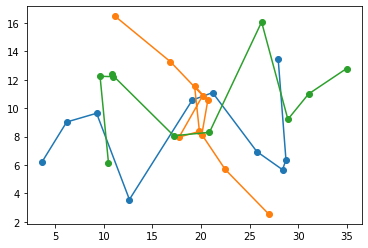

In [6]:
print(lines)

for line in lines:
    x_coordinates = [point[0] for point in line]
    y_coordinates = [point[1] for point in line]
    plt.plot(x_coordinates, y_coordinates, '-o')

plt.show()

### 5. Aggregation (FL)

distance-based

Take pair wise lines,
    calculate distance between two lines:
        same_idx_dist <- sum of distances between pairs of centers of same indices
        inv_idx_dist <- sum of distances between paris of centers of inverted indices
        dist <- min(same_idx_dist, inv_idx_dist)

use Ward's clustering (https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.ward.html)



[[ 0.          2.         54.53015226  2.        ]
 [ 1.          3.         86.53725685  3.        ]]
[array([[[ 3.66101695,  6.23728814],
        [ 6.18181818,  9.03030303],
        [ 9.25806452,  9.64516129],
        [12.63636364,  3.57575758],
        [19.09623431, 10.56903766],
        [21.19211823, 11.09852217],
        [25.73809524,  6.95238095],
        [28.3877551 ,  5.67346939],
        [28.73913043,  6.36956522],
        [27.93846154, 13.46153846]]]), array([[ 3.66101695,  6.23728814],
       [ 6.18181818,  9.03030303],
       [ 9.25806452,  9.64516129],
       [12.63636364,  3.57575758],
       [19.09623431, 10.56903766],
       [21.19211823, 11.09852217],
       [25.73809524,  6.95238095],
       [28.3877551 ,  5.67346939],
       [28.73913043,  6.36956522],
       [27.93846154, 13.46153846]]), array([[[34.97014925, 12.79104478],
        [31.05882353, 11.        ],
        [28.9375    ,  9.21875   ],
        [26.23333333, 16.06666667],
        [20.86915888,  8.30373832],
 

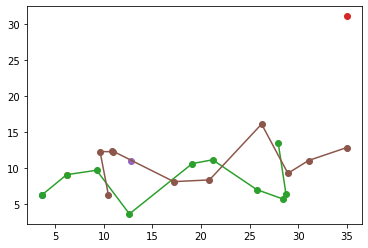

In [8]:
def distance(l1,l2):
    "l1 and l2 need to be 2 dimensional numpy arrays"
    distance_normal = 0
    distance_reversed = 0
    for i in range(len(l1)):
        distance_normal += np.linalg.norm(l1[i] - l2[i])
        distance_reversed += np.linalg.norm(l1[i] - l2[-(i+1)])
    l = [distance_normal, distance_reversed]
    return min(l),np.where(l == min(l))[0][0] # [0][0] to get an int instead of an array


def create_distance_matrix(lines):
    # create mattrix that shows if the pairwise distance is revesed or not
    n_lines = lines.shape[0]
    matrix = np.empty((n_lines,n_lines))
    normal_or_not = np.empty((n_lines,n_lines))
    for i in range(n_lines):
        for j in range(n_lines):
            if i == j:
                matrix[i,j] = np.inf
                normal_or_not[i,j] = -1
            else:
                matrix[i,j] = distance(lines[i],lines[j])[0]
                normal_or_not[i,j] = distance(lines[i],lines[j])[1]

    return np.triu(matrix,1), normal_or_not


def assign_clusters(d_matrix,threshold,print_Z=False):
    Z = ward(d_matrix[d_matrix > 0])
    # see link for explanation of Z
    # https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster
    if print_Z:
        print(Z)
    assigned_clusters = fcluster(Z, threshold, criterion='distance')
    return assigned_clusters

def average_lines(lines,clusters,r_matrix):
    ''' averages x,y values of all lines per cluster
    '''
    final_lines = []
    for i in range(max(clusters)-1): #iterate trough clusters
        cluster_lines = np.where(clusters == i + 1)
        if len(cluster_lines) == 1:
            final_lines.append(lines[cluster_lines[0]])


        first_ind = cluster_lines[0][0]
        averaged_line = lines[first_ind]
        for compare_ind in cluster_lines[0]:   #itearate trough lines
            if r_matrix[first_ind, compare_ind] == 0:  # normal distance
                averaged_line = averaged_line + lines[compare_ind]

            elif r_matrix[first_ind, compare_ind] == 1:  # reverse distance
                averaged_line = averaged_line + np.flip(lines[compare_ind])
        averaged_line = averaged_line / len(cluster_lines)
        final_lines.append(averaged_line)
    return final_lines


def aggregate(lines,threshold,print_z=False):
    d_matrix, r_matrix = create_distance_matrix(lines)
    clusters = assign_clusters(d_matrix, threshold,print_Z=print_z)
    new_lines = average_lines(lines, clusters, r_matrix)
    return new_lines


agg_lines = aggregate(lines,22,True)
for line in agg_lines:
    x_coordinates = [point[0] for point in line]
    y_coordinates = [point[1] for point in line]
    plt.plot(x_coordinates, y_coordinates, '-o')

#print(agg_lines)

### 6. Selection

See Algorithm 1 (NEU07_wsom paper)
select only components with a small amount of regions per bin



### 7. Snapping

See Algorithm 1 (https://github.com/yozoon/SOM-MetroMap/blob/main/implementation_report.pdf)

See implementation of template method `_find_snapped_line`



## References